In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
from itertools import cycle, islice
from lib.nyt_connections import get_connections_games
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.tasks import get_task_results, Task
from lib.tokenize import TaskResultTokenizer
import openai
from openai.types.chat.chat_completion import Choice
import os
from transformers import AutoTokenizer
from typing import Iterable


games = get_connections_games()
games

[ConnectionsGame(board={'WET WEATHER': ConnectionsGroup(level=0, members=['HAIL', 'RAIN', 'SLEET', 'SNOW']), 'NBA TEAMS': ConnectionsGroup(level=1, members=['BUCKS', 'HEAT', 'JAZZ', 'NETS']), 'KEYBOARD KEYS': ConnectionsGroup(level=2, members=['OPTION', 'RETURN', 'SHIFT', 'TAB']), 'PALINDROMES': ConnectionsGroup(level=3, members=['KAYAK', 'LEVEL', 'MOM', 'RACECAR'])}, starting_board=[['SNOW', 'LEVEL', 'SHIFT', 'KAYAK'], ['HEAT', 'TAB', 'BUCKS', 'RETURN'], ['JAZZ', 'HAIL', 'OPTION', 'RAIN'], ['SLEET', 'RACECAR', 'MOM', 'NETS']], created_at=datetime.datetime(2023, 6, 12, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')), id=1, name='Connections #1'),
 ConnectionsGame(board={'FOOTWEAR': ConnectionsGroup(level=0, members=['BOOT', 'LOAFER', 'PUMP', 'SNEAKER']), 'UNITS OF LENGTH': ConnectionsGroup(level=1, members=['FOOT', 'LEAGUE', 'MILE', 'YARD']), 'MAGAZINES': ConnectionsGroup(level=2, members=['ESSENCE', 'PEOPLE', 'TIME', 'US']), 'LETTER HOMOPHONES': ConnectionsGroup(level=3, members=['ARE', 'Q

In [4]:
prompts = [
    "Find groups of four items that share something in common. Output them in the following format: four total lines. On each line, there should be four comma-separated items. No additional text (like group titles or descriptions) should be in the output. Also, there should not be anything in your output before or after the solution.",
    "Group words that share a common thread. There are four words for each common thread. Output them in the following format: four total lines. On each line, there should be four comma-separated items. No additional text (like group titles or descriptions) should be in the output. Also, there should not be anything in your output before or after the solution.",
    "This is a puzzle. Create four groups of four. Words in each group fit under a specific category. Some categories might be defined by their use of wordplay (palindromes, homophones, adding or dropping letters and words) rather than the literal meanings of the words on the cards. Output them in the following format: four total lines. On each line, there should be four comma-separated items. No additional text (like group titles or descriptions) should be in the output. Also, there should not be anything in your output before or after the solution.",
]


def get_tasks() -> Iterable[Task]:
    for game, (prompt, lowercase) in zip(
        cycle(games),
        cycle((prompt, lowercase) for prompt in prompts for lowercase in [True, False]),
    ):

        def grader(choice: Choice, game=game) -> float:
            assistant_content = choice.message.content
            assert assistant_content is not None
            assistant_content = assistant_content.strip()
            groups = [
                frozenset(word.strip().upper() for word in line.split(","))
                for line in assistant_content.split("\n")[-len(game.board) :]
            ]
            reward = 0
            for _, group_contents in game.board.items():
                if set(group_contents.members) in groups:
                    reward += 1 / len(game.board)
            return reward

        yield Task(
            messages=[
                {
                    "role": "user",
                    "content": f"{prompt}\nWords:\n\n{"\n".join(word.lower() if lowercase else word for row in game.starting_board for word in row)}",
                }
            ],
            grader=grader,
        )


tasks = list(islice(get_tasks(), len(games) * 2))
# distill_tasks = tasks[:436]
distill_tasks = tasks[:100]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

(100, 72, 92, 436)

In [5]:
base_model = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
tokenizer = AutoTokenizer.from_pretrained(base_model)

distill_client = openai.AsyncOpenAI(
    base_url="https://api.fireworks.ai/inference/v1",
    api_key=os.getenv("FIREWORKS_API_KEY"),
)
distill_model = "accounts/fireworks/models/deepseek-r1"

tokenized_results = await get_task_results(
    tasks=distill_tasks,
    client=distill_client,
    model=distill_model,
    transform=TaskResultTokenizer(tokenizer),
)
print(
    "Max sequence length:",
    max(len(tokenized_result.token_ids) for tokenized_result in tokenized_results),
)
print("Number of results with no logprobs:", sum(1 for tokenized_result in tokenized_results if tokenized_result.token_logprobs is None))

  0%|          | 0/100 [00:00<?, ?it/s]

Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Max sequence length: 11534
Number of results with no logprobs: 6


Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping


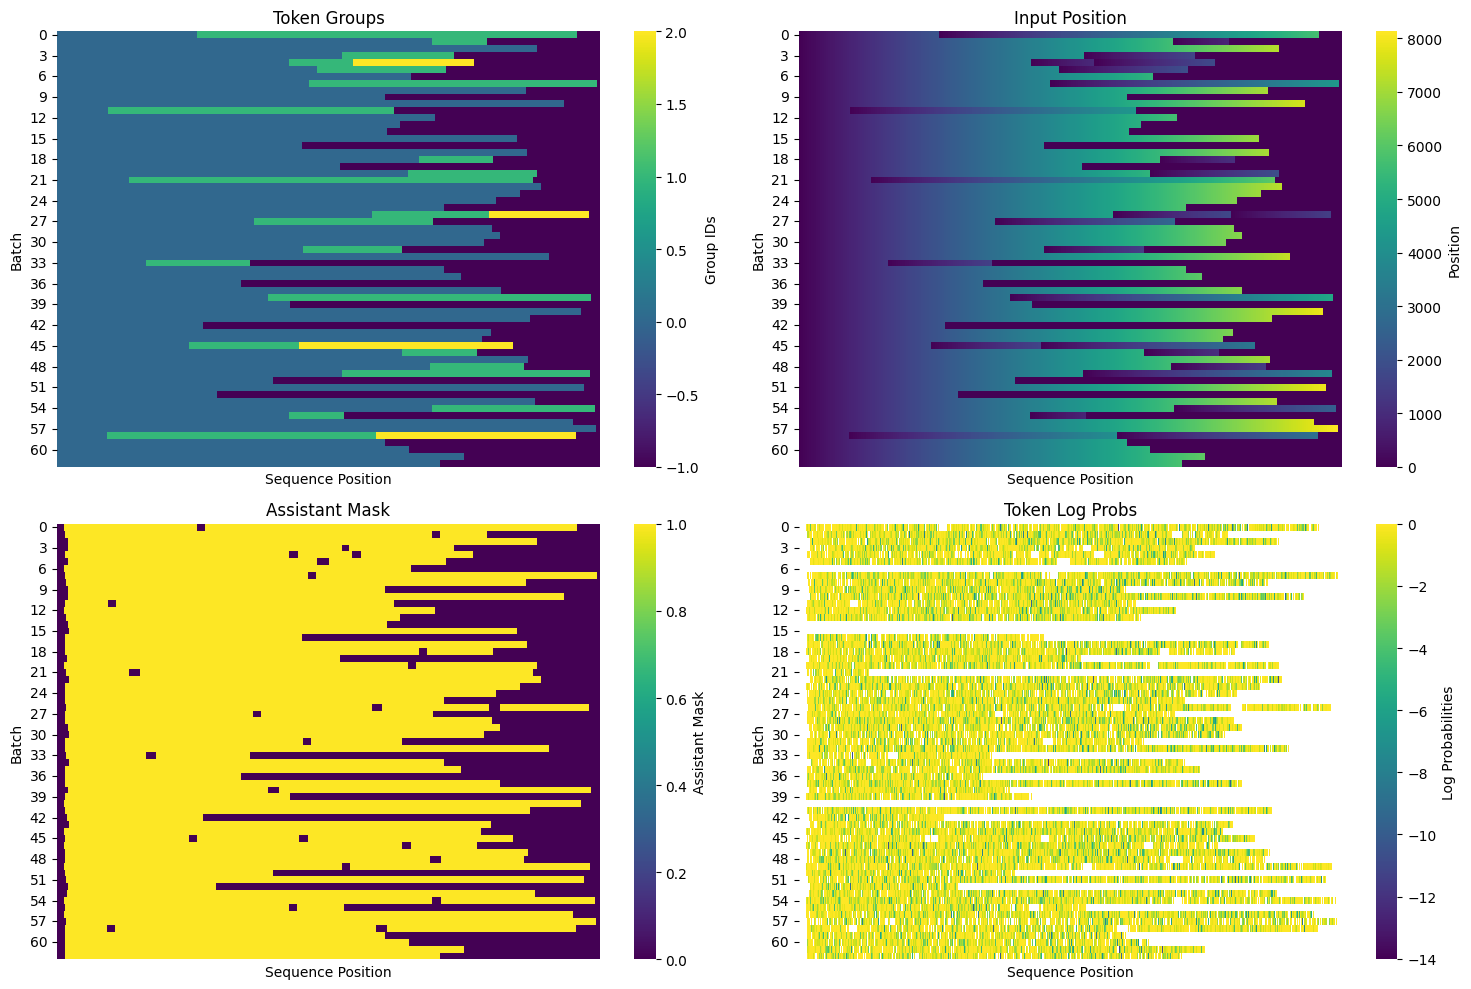

{'tokens': tensor([[151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   2808,  ..., 151643, 151643, 151643],
         [151646, 151644,   1986,  ..., 151643, 151643, 151643],
         ...,
         [151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   2808,  ..., 151643, 151643, 151643],
         [151646, 151644,   2808,  ..., 151643, 151643, 151643]]),
 'group_ids': tensor([[ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         ...,
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1]]),
 'input_pos': tensor([[0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         ...,
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0]]),
 'assistant_mask': tensor([[False, False, False,  ..., False, False, F

In [6]:
packed_tensors = packed_tensors_from_tokenized_results(tokenized_results, 8192, pad_token_id=tokenizer.pad_token_id)
plot_packed_tensors(packed_tensors)
packed_tensors

In [7]:
from lib.recipe import TuneRecipeConfig
from omegaconf import OmegaConf

config = TuneRecipeConfig(
    enable_activation_checkpointing=True,
)
config

{'device': 'cuda', 'dtype': 'bf16', 'optimizer': {'_component_': 'torch.optim.AdamW', 'lr': 2e-05, 'fused': True}, 'resume_from_checkpoint': False, 'gradient_accumulation_steps': 1, 'checkpointer': None, 'seed': None, 'epochs': 1, 'max_steps_per_epoch': None, 'metric_logger': None, 'model': None, 'loss': {'_component_': <class 'lib.grpo.GRPO'>}, 'dataset': None, 'shuffle': False, 'batch_size': 1, 'enable_activation_checkpointing': True}

In [8]:
import asyncio

process = await asyncio.create_subprocess_shell(
    f"HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download {base_model}",
    stdout=asyncio.subprocess.PIPE,
    stderr=asyncio.subprocess.PIPE,
)
stdout, _ = await process.communicate()
base_checkpoint_dir = stdout.decode().strip()
base_checkpoint_dir

'/home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247'

In [9]:
import glob
from lib.mlp_head_checkpointer import MLPHeadCheckpointer
from lib.pack import PackedDataset, packed_tensors_to_dir
from lib.recipe import ComponentConfig
from torchtune.models.qwen2_5 import qwen2_5_7b_base
from torchtune.training import FullModelHFCheckpointer
from torchtune.training.metric_logging import DiskLogger


def get_checkpointer_config(
    checkpoint_dir: str,
    output_dir: str,
    tune_model_type: str,
    checkpoint_files: list[str] | None = None,
    mlp_head_checkpointer: bool = False,
    output_subdir: str = "",
) -> ComponentConfig[FullModelHFCheckpointer]:
    return ComponentConfig(
        MLPHeadCheckpointer if mlp_head_checkpointer else FullModelHFCheckpointer,
        checkpoint_dir=checkpoint_dir,
        checkpoint_files=checkpoint_files
        or [
            file
            for ext in ["safetensors", "pt", "ckpt", "bin", "pth"]
            for file in glob.glob(f"{checkpoint_dir}/*.{ext}")
            if not file.endswith("mlp_head.pt")
        ],
        recipe_checkpoint=None,
        output_dir=output_dir + output_subdir,
        model_type=tune_model_type,
    )


output_dir = "./models/rl1"
tune_model_type = "QWEN2"


config.checkpointer = get_checkpointer_config(
    checkpoint_dir=base_checkpoint_dir,
    output_dir=output_dir,
    tune_model_type=tune_model_type,
)
config.reference_checkpointer = get_checkpointer_config(
    checkpoint_dir=base_checkpoint_dir,
    output_dir=output_dir,
    tune_model_type=tune_model_type,
)
config.metric_logger = ComponentConfig(DiskLogger, log_dir=f"{output_dir}/logs")
config.model = ComponentConfig(qwen2_5_7b_base)
disk_packed_tensors = packed_tensors_to_dir(packed_tensors, f"{output_dir}/tensors")
config.dataset = ComponentConfig(
    PackedDataset,
    **disk_packed_tensors,
)
config.seed = 42
dict_config = config.dict_config()
print(OmegaConf.to_yaml(dict_config))
OmegaConf.save(dict_config, f"{output_dir}/config.yaml")

device: cuda
dtype: bf16
optimizer:
  _component_: torch.optim.AdamW
  lr: 2.0e-05
  fused: true
resume_from_checkpoint: false
gradient_accumulation_steps: 1
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  recipe_checkpoint: null
  output_dir: ./models/rl1
  model_type: QWEN2
seed: 42
epochs: 1
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_logging.DiskLogger
  log_dir: ./models/rl1/log

Final mask shape: torch.Size([63, 8192, 8192])


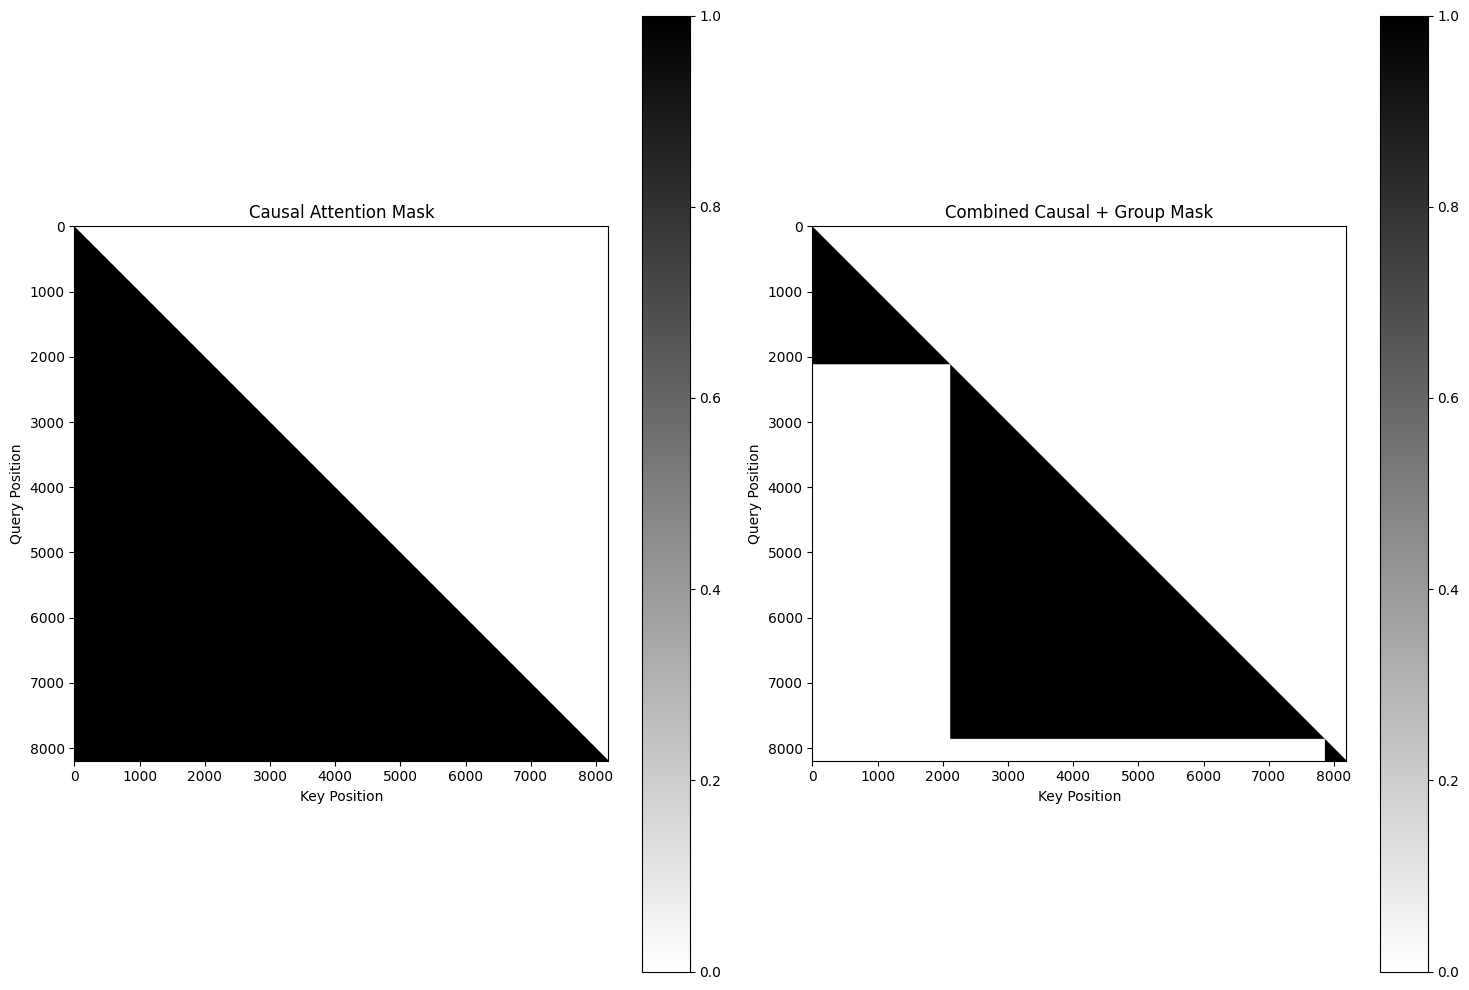

Mask shape: torch.Size([63, 8192, 8192])
Number of allowed attention connections (True values): 1263707944
Percentage of allowed connections: 29.9%


In [10]:
import torch

shape = packed_tensors["tokens"].shape

# Create causal attention mask for the batch size and sequence length
batch_size = shape[0]
seq_length = shape[1]

causal_mask = (
    torch.tril(torch.ones(seq_length, seq_length, dtype=torch.bool))
    .unsqueeze(0)
    .expand(batch_size, seq_length, seq_length)
)
group_mask = packed_tensors["group_ids"].unsqueeze(2) == packed_tensors[
    "group_ids"
].unsqueeze(1)
final_mask = causal_mask & group_mask

# Verify mask shape matches batch size and sequence length
print(f"Final mask shape: {final_mask.shape}")

# Visualize the combined attention mask
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Plot causal mask
mask_example = causal_mask[0].cpu().numpy()
im1 = ax1.imshow(mask_example, cmap="binary")
ax1.set_title("Causal Attention Mask")
ax1.set_xlabel("Key Position")
ax1.set_ylabel("Query Position")
plt.colorbar(im1, ax=ax1)

# Plot combined mask
final_mask_example = final_mask[0].cpu().numpy()
im2 = ax2.imshow(final_mask_example, cmap="binary")
ax2.set_title("Combined Causal + Group Mask")
ax2.set_xlabel("Key Position")
ax2.set_ylabel("Query Position")
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mask shape: {final_mask.shape}")
print(
    f"Number of allowed attention connections (True values): {final_mask.sum().item()}"
)
print(
    f"Percentage of allowed connections: {final_mask.sum().item() / (final_mask.numel()) * 100:.1f}%"
)

In [12]:
from lib.tqdm import tqdm
import re
import sys
from typing import Any, IO, Literal

Verbosity = Literal[0, 1, 2]


async def tune_run(
    config_path: str,
    total: int,
    verbosity: Verbosity = 2,
    torchrun_kwargs: dict[str, Any] | None = None,
    tune_run_env: dict[str, str] | None = None,
) -> None:
    args = [
        "tune",
        "run",
        *[
            f"--{key.replace('_', '-')}{f'={value}' if value is not True else ''}"
            for key, value in (torchrun_kwargs or {}).items()
        ],
        "lib.recipe.TuneRecipe",
        "--config",
        config_path,
    ]
    if verbosity > 0:
        print(f"$ {' '.join(args)}")
    process = await asyncio.create_subprocess_exec(
        *args,
        stdout=asyncio.subprocess.PIPE,
        stderr=asyncio.subprocess.PIPE,
        env={**os.environ, **(tune_run_env or {})},
    )
    if verbosity == 1:
        pbar = tqdm.tqdm(total=total)
    else:
        pbar = None

    async def log_output(stream: asyncio.StreamReader, io: IO[str]) -> None:
        output = ""
        while True:
            try:
                chunk = await stream.read(4096)
                if not chunk:
                    break
                output += chunk.decode()
                if verbosity > 1:
                    io.write(output)
                    io.flush()
                    output = ""
                elif verbosity == 1:
                    output = output.split("\n")[-1]
                    if pbar:
                        pbar_start = re.compile(r"(\d+)\|(\d+)\|Loss: ([\d.]+):")
                        if match := pbar_start.search(output):
                            epoch, step, loss = match.groups()
                            pbar.update(int(step) - pbar.n)
                            pbar.set_description(f"{epoch}|{step}|Loss: {loss}")
                        metrics = {
                            key: value
                            for key, value in re.findall(r"(\w+)=([\d.-]+)", output)
                        }
                        if metrics:
                            pbar.set_postfix(**metrics)
                            output = ""
                    else:
                        pbar_regex = re.compile(
                            r"\[(?:\d+:)?\d+:\d+<(?:\d+:)?\d+:\d+.*\]"
                        )
                        if pbar_regex.search(output):
                            io.write(output)
                            io.flush()
                            output = ""
            except Exception:
                break

    tasks = []
    if process.stdout:
        tasks.append(asyncio.create_task(log_output(process.stdout, sys.stdout)))
    if process.stderr:
        tasks.append(asyncio.create_task(log_output(process.stderr, sys.stderr)))
    _ = await asyncio.gather(*tasks)
    if pbar:
        pbar.close()


await tune_run(
    config_path=f"{output_dir}/config.yaml",
    total=disk_packed_tensors["num_sequences"],
    verbosity=2,
    tune_run_env={
        "CUDA_LAUNCH_BLOCKING": "1",
    },
)

$ tune run lib.recipe.TuneRecipe --config ./models/rl1/config.yaml


DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 1
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/rl1
  recipe_checkpoint: null
dataset:
  _component_: lib.pack.P

Writing logs to models/rl1/logs/log_1739417336.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.78 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 18.29 GiB
	GPU peak memory reserved: 18.39 GiB
	GPU peak memory active: 18.29 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|63|Loss: 1.1026: 100%|██████████| 63/63 [07:59<00:00,  7.28s/it, loss=1.1, lr=2e-5]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 0.00 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved to models/rl1/hf_model_0001_0.pt
I